# Imports

In [1]:
from cytoflow import *
import os

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["pdf.fonttype"] = 42
sns.set_style(
    "ticks",
    {
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "font_color": "k",
        "axes.edgecolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)
sns.set_context("talk", font_scale=1.0)

# Setting up the plate & tube loader functions

In [2]:
day_dict = {
    5: "axm-20220417_repadd_stapl_d5-20220417-1727",
    4: "axm-20220416_repadd_stapl_d4-20220416-1925",
    3: "axm-20220415_repadd_stapl_d3-20220415-1559",
    2: "axm-20220414_repadd_stapl_d2-20220414-1502",
    1: "axm-20220413_repadd_stapl_d1-20220413-1604",
    0: "axm-20220412_repadd_stapl_d0-20220412-1646",
}

plasmid_dict = {
    126: "rTetR-only",
    77: "ZNF10-CBX1",
    181: "ZNF10-Rand372",
    182: "Rand372-CBX1",
    76: "ZNF10-ANM2",
    183: "Rand372-ANM2",
    140: "FOXO3-ZNF10",
    184: "Rand372-FOXO3",
    90: "NOTC2-ANM2",
    188: "NOTC2-Rand372",
    91: "NOTC2-KIBRA",
    138: "KIBRA-DMD297",
    217: "ZNF10-only",
    222: "FOXO3-only",
    56: "STaPL-only",
    73: "FOXO3-STaPL-ZNF10",
}

repadd_plasmids = [126, 77, 181, 182, 76, 183, 140, 184, 90, 188, 91, 138]

repadd_layout = [[126, 77, 181, 182, 76, 183], [140, 184, 90, 188, 91, 138]]
stapl_layout = [126, 217, 222, 56, 140, 73]

plate_rows = ["A", "B", "C", "D", "E", "F", "G", "H"]
plate_cols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
stapl_row_dict = {  # dox => asv => replicate
    0: {0: {1: "F", 2: "B"}, 1: {1: "A", 2: "E"}},
    1000: {0: {1: "H", 2: "D"}, 1: {1: "C", 2: "G"}},
}

In [3]:
def get_well(stapl_status, plasmid, replicate, asv, dox):
    if stapl_status:
        col = plate_cols[6 + stapl_layout.index(plasmid)]
        row = stapl_row_dict[dox][asv][replicate]
    else:
        offset = 0 if plasmid in repadd_layout[0] else 1
        col = plate_cols[repadd_layout[offset].index(plasmid)]
        row = plate_rows[4 * (dox==1000) + 2 * (replicate-1) + offset]
    return row + str(col)


def get_tube(day, stapl_status, plasmid, replicate, asv, dox):
    return (
        "./fcs/"
        + day_dict[day]
        + "/"
        + get_well(stapl_status, plasmid, replicate, asv, dox)
        + ".fcs"
    )

In [4]:
get_well(False, 181, 1, 0, 0)

'A3'

# Importing tubes

In [5]:
tubeslist = []

# repressor additivity
for day in [0, 1, 2, 3, 4, 5]:
    for dox in [0, 1000]:
        for plasmid in repadd_plasmids:
            for replicate in [1, 2]:
                tubeslist.extend(
                    [
                        Tube(
                            conditions={
                                "plasmid": plasmid,
                                "description": plasmid_dict[plasmid],
                                "day": day,
                                "dox": dox,
                                "asv": 0,
                                "replicate": replicate,
                            },
                            file=get_tube(day, False, plasmid, replicate, 0, dox),
                            conditions_list=[
                                "plasmid",
                                "description",
                                "day",
                                "dox",
                                "asv",
                                "replicate",
                            ],
                        )
                    ]
                )

# stapl testing
for day in [0, 1, 2, 3, 4, 5]:
    for dox in [0, 1000]:
        for plasmid in stapl_layout:
            for asv in [0, 1]:
                for replicate in [1, 2]:
                    tubeslist.extend(
                        [
                            Tube(
                                conditions={
                                    "plasmid": plasmid,
                                    "description": plasmid_dict[plasmid],
                                    "day": day,
                                    "dox": dox,
                                    "asv": asv,
                                    "replicate": replicate,
                                },
                                file=get_tube(day, True, plasmid, replicate, asv, dox),
                                conditions_list=[
                                    "plasmid",
                                    "description",
                                    "day",
                                    "dox",
                                    "asv",
                                    "replicate",
                                ],
                            )
                        ]
                    )

print("Loaded", len(tubeslist), "tubes")

Loaded 576 tubes


In [6]:
def get_ex0(tube):
    op0 = ImportOp(
        conditions={
            "plasmid" : "category",
            "description" : "category",
            "day" : "float",
            "dox" : "float",
            "asv" : "float",
            "replicate" : "float"
        },
        tubes=[tube],
        channels={
            "mCitrine-A": "mCitrine-A",
            "mCherry-A": "mCherry-A",
            "FSC 488/10-A": "FSC 488/10-A",
            "SSC 488/10-A": "SSC 488/10-A",
        },
    )
    ex0 = op0.apply()
    return ex0


ex0_list = [get_ex0(t) for t in tqdm(tubeslist)]
all_data = pd.concat([e.data for e in tqdm(ex0_list)])
ex0 = ex0_list[0]
ex0.data = all_data
ex0.data.head()

  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

,FSC 488/10-A,SSC 488/10-A,asv,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate
0,362866944.0,144733952.0,0.0,0.0,rTetR-only,0.0,1.303086e+08,89980672.0,126,1.0
1,334863104.0,224061440.0,0.0,0.0,rTetR-only,0.0,6.038436e+08,135963392.0,126,1.0
2,345659904.0,81310720.0,0.0,0.0,rTetR-only,0.0,1.789588e+08,10406912.0,126,1.0
3,485317888.0,192180224.0,0.0,0.0,rTetR-only,0.0,1.976110e+08,1438976.0,126,1.0
4,388297728.0,192445952.0,0.0,0.0,rTetR-only,0.0,1.121067e+09,60152320.0,126,1.0


# Live Cells, mCherry Gating

CPU times: user 49 s, sys: 5.01 s, total: 54 s
Wall time: 24.7 s


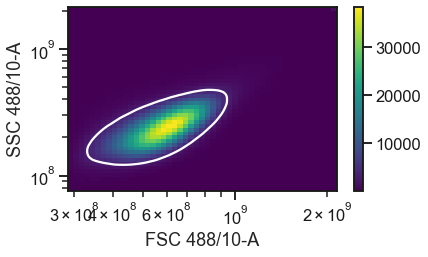

In [7]:
%%time

dens_op = DensityGateOp(
    name="P1",
    xchannel="FSC 488/10-A",
    xscale="log",
    ychannel="SSC 488/10-A",
    yscale="log",
    keep=0.9,
)

dens_op.estimate(ex0)
ex_1 = dens_op.apply(ex0)
dens_op.default_view().plot(ex0, height=4)

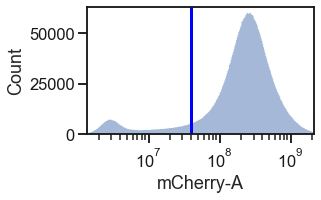

In [8]:
op_2 = ThresholdOp(name="mCherry", threshold=4e7, channel="mCherry-A")
ex_2 = op_2.apply(ex_1)
op_2.default_view(subset="(P1==True)", scale="log").plot(ex_2)

In [9]:
all_cells = ex_2.data
all_cells = all_cells[(all_cells['P1'])&(all_cells['mCherry'])]
all_cells.to_csv('./data/all_cells_mch_live.csv', index=False)
all_cells

,FSC 488/10-A,SSC 488/10-A,asv,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry
0,362866944.0,144733952.0,0.0,0.0,rTetR-only,0.0,1.303086e+08,89980672.0,126,1.0,True,True
1,334863104.0,224061440.0,0.0,0.0,rTetR-only,0.0,6.038436e+08,135963392.0,126,1.0,True,True
2,345659904.0,81310720.0,0.0,0.0,rTetR-only,0.0,1.789588e+08,10406912.0,126,1.0,True,True
3,485317888.0,192180224.0,0.0,0.0,rTetR-only,0.0,1.976110e+08,1438976.0,126,1.0,True,True
4,388297728.0,192445952.0,0.0,0.0,rTetR-only,0.0,1.121067e+09,60152320.0,126,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6122,577804032.0,285295616.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,2.335444e+08,2189312.0,73,2.0,True,True
6123,547161344.0,174424064.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,1.203738e+08,2744576.0,73,2.0,True,True
6124,487039744.0,205412608.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,1.165202e+08,2241792.0,73,2.0,True,True
6125,542076160.0,148063744.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,1.569377e+08,1620992.0,73,2.0,True,True


# mCitrine Gating

In [10]:
df = all_cells.copy()
df

,FSC 488/10-A,SSC 488/10-A,asv,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry
0,362866944.0,144733952.0,0.0,0.0,rTetR-only,0.0,1.303086e+08,89980672.0,126,1.0,True,True
1,334863104.0,224061440.0,0.0,0.0,rTetR-only,0.0,6.038436e+08,135963392.0,126,1.0,True,True
2,345659904.0,81310720.0,0.0,0.0,rTetR-only,0.0,1.789588e+08,10406912.0,126,1.0,True,True
3,485317888.0,192180224.0,0.0,0.0,rTetR-only,0.0,1.976110e+08,1438976.0,126,1.0,True,True
4,388297728.0,192445952.0,0.0,0.0,rTetR-only,0.0,1.121067e+09,60152320.0,126,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6122,577804032.0,285295616.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,2.335444e+08,2189312.0,73,2.0,True,True
6123,547161344.0,174424064.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,1.203738e+08,2744576.0,73,2.0,True,True
6124,487039744.0,205412608.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,1.165202e+08,2241792.0,73,2.0,True,True
6125,542076160.0,148063744.0,1.0,5.0,FOXO3-STaPL-ZNF10,1000.0,1.569377e+08,1620992.0,73,2.0,True,True


## Defining the mCitrine threshold

  0%|          | 0/6 [00:00<?, ?it/s]

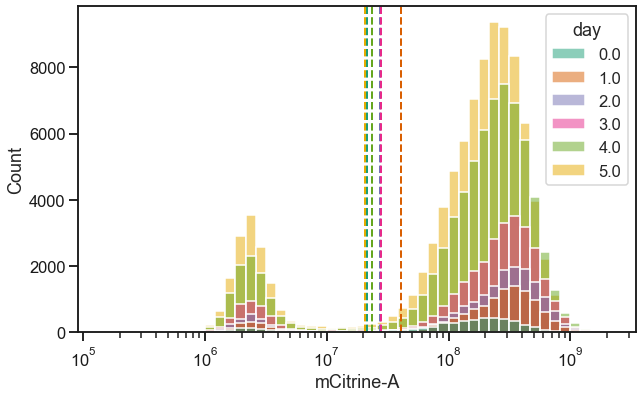

In [11]:
data = df[df["plasmid"] == 126]
data = data[data["asv"] == 0]
data = data[data["dox"] == 0]


def get_citrine_threshold(day):
    dx = df
    dx = dx[dx["day"] == day]
    dx = dx[dx["plasmid"] == 126]
    dx = dx[dx["dox"] == 0]
    dx = dx[dx["asv"] == 0]

    logmC = np.log10(dx["mCitrine-A"])

    gm = GaussianMixture(n_components=2).fit(np.array(logmC).reshape(-1, 1))
    m0 = gm.means_[0][0]
    m1 = gm.means_[1][0]
    c0 = gm.covariances_[0][0]
    c1 = gm.covariances_[1][0]
    mean = m0 if m0 <= m1 else m1
    cov = c0 if m0 <= m1 else c1
    # return [10**7]
    return np.power(10, mean + 5 * np.sqrt(cov))


g = sns.histplot(
    data=data, x="mCitrine-A", hue="day", palette="Dark2", log_scale=True, bins=50
)

days = [0, 1, 2, 3, 4, 5]

for d in tqdm(days):
    g.axvline(
        x=get_citrine_threshold(d),
        color=list(sns.color_palette("Dark2"))[days.index(d)],
        linestyle="--",
        lw=2,
    )

## Pivoting, computing normalized OFF fractions

In [12]:
%%time
daylist = [0, 1, 2, 3, 4, 5]
day_thresh_dict = {d: get_citrine_threshold(d) for d in tqdm(daylist)}
thresh = np.vectorize(day_thresh_dict.get)(df["day"])
df["mCitrine On"] = df["mCitrine-A"] > thresh
data = df[['plasmid', 'description', 'day', 'asv', 'dox', 'replicate', 'mCitrine On']]
data = data.reset_index(drop = True)
data

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 10.4 s, sys: 1.11 s, total: 11.5 s
Wall time: 1.84 s


,plasmid,description,day,asv,dox,replicate,mCitrine On
0,126,rTetR-only,0.0,0.0,0.0,1.0,True
1,126,rTetR-only,0.0,0.0,0.0,1.0,True
2,126,rTetR-only,0.0,0.0,0.0,1.0,False
3,126,rTetR-only,0.0,0.0,0.0,1.0,False
4,126,rTetR-only,0.0,0.0,0.0,1.0,True
...,...,...,...,...,...,...,...
3942195,73,FOXO3-STaPL-ZNF10,5.0,1.0,1000.0,2.0,False
3942196,73,FOXO3-STaPL-ZNF10,5.0,1.0,1000.0,2.0,False
3942197,73,FOXO3-STaPL-ZNF10,5.0,1.0,1000.0,2.0,False
3942198,73,FOXO3-STaPL-ZNF10,5.0,1.0,1000.0,2.0,False


In [13]:
%%time
gdf = (
    data.groupby(["plasmid", "description", "day", "asv", "dox", "replicate"])
    .mean()
    .reset_index()
)
gdf = gdf.pivot(
    index=["plasmid", "description", "day", "asv", "replicate"],
    columns="dox",
    values="mCitrine On",
).reset_index()
gdf["norm Citrine Off"] = (gdf[0] - gdf[1000]) / gdf[0]
gdf = gdf[
    ["plasmid", "description", "day", "asv", "replicate", "norm Citrine Off"]
]
gdf.to_csv("./data/plasmids_norm_cit_off.csv", index=False)
gdf

CPU times: user 697 ms, sys: 153 ms, total: 850 ms
Wall time: 854 ms


dox,plasmid,description,day,asv,replicate,norm Citrine Off
0,56,STaPL-only,0.0,0.0,1.0,0.046305
1,56,STaPL-only,0.0,0.0,2.0,0.026218
2,56,STaPL-only,0.0,1.0,1.0,0.002184
3,56,STaPL-only,0.0,1.0,2.0,0.010918
4,56,STaPL-only,1.0,0.0,1.0,0.006597
...,...,...,...,...,...,...
259,222,FOXO3-only,4.0,1.0,2.0,0.414913
260,222,FOXO3-only,5.0,0.0,1.0,0.462764
261,222,FOXO3-only,5.0,0.0,2.0,0.471438
262,222,FOXO3-only,5.0,1.0,1.0,0.415241


# Drawing Lineplots

## STaPL testing

In [14]:
print(set(gdf['plasmid']))
print(stapl_layout)

{73, 138, 76, 77, 140, 184, 181, 182, 183, 56, 217, 90, 91, 188, 222, 126}
[126, 217, 222, 56, 140, 73]


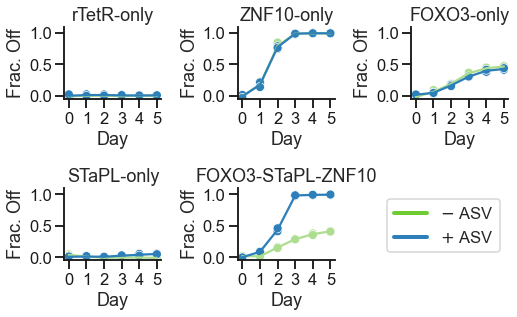

In [15]:
sdf = gdf[gdf["plasmid"].isin(stapl_layout)]
stapl_palette = ["#addd8e", "#2c7fb8"]


def plot_curve(px, ax):
    pdf = sdf[sdf["plasmid"] == px]

    sns.scatterplot(
        data=pdf,
        x="day",
        y="norm Citrine Off",
        hue="asv",
        palette=stapl_palette,
        legend=False,
        ax=ax,
    )

    sns.lineplot(
        data=pdf,
        x="day",
        y="norm Citrine Off",
        hue="asv",
        palette=stapl_palette,
        ci=None,
        legend=False,
        ax=ax,
    )

    ax.set_ylim(-0.05, 1.1)
    ax.set_xlim(-0.25, 5.25)

    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_yticks([0, 0.5, 1.0])

    ax.set_xlabel("Day")
    ax.set_ylabel("Frac. Off")

    ax.set_title(plasmid_dict[px])


fig, axes = plt.subplots(2, 3, figsize=(7.5, 4.75))

for i, ax in enumerate(axes.flat[:-1]):
    plot_curve([126, 217, 222, 56, 73][i], ax)

axes.flat[-1].set_visible(False)

sns.despine(fig)
plt.tight_layout()

custom_lines = [
    Line2D([0], [0], color="#70cc33", lw=4),
    Line2D([0], [0], color="#2c7fb8", lw=4),
]
axes.flat[0].legend(
    custom_lines,
    ["$\minus$ ASV", "$\plus$ ASV"],
    loc="center left",
    bbox_to_anchor=(3.25, -1.75),
)

fig.savefig("./plots/stapl_pef_summary_aspected.pdf", bbox_inches="tight")
fig.savefig("./plots/stapl_pef_summary_aspected.png", dpi=600)

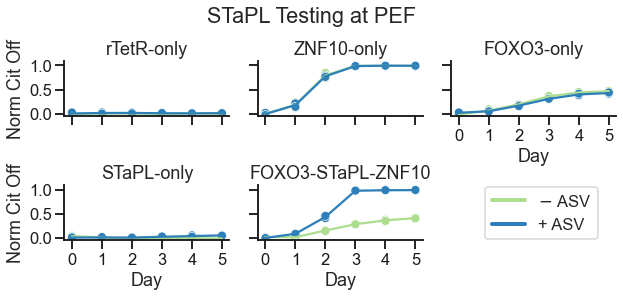

In [16]:
sdf = gdf[gdf["plasmid"].isin(stapl_layout)]

g = sns.FacetGrid(
    data=sdf,
    col="plasmid",
    col_wrap=3,
    sharex=True,
    sharey=True,
    height=2,
    aspect=1.5,
    col_order=[126, 217, 222, 56, 73],
)

stapl_palette = ["#addd8e", "#2c7fb8"]

g.map_dataframe(
    sns.lineplot,
    x="day",
    y="norm Citrine Off",
    hue="asv",
    palette=stapl_palette,
    ci=None,
)

g.map_dataframe(
    sns.scatterplot,
    x="day",
    y="norm Citrine Off",
    hue="asv",
    palette=stapl_palette,
)

for i, ax in enumerate(g.axes):
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlim(-0.25, 5.25)

    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_yticks([0, 0.5, 1.0])

    ax.set_title(plasmid_dict[[126, 217, 222, 56, 73][i]])

g.axes[2].set_xlabel("Day")
g.axes[4].set_xlabel("Day")
g.axes[3].set_xlabel("Day")
g.axes[0].set_ylabel("Norm Cit Off")
g.axes[3].set_ylabel("Norm Cit Off")


g.tight_layout()
g.fig.suptitle("STaPL Testing at PEF", y=1.05)


custom_lines = [
    Line2D([0], [0], color=stapl_palette[0], lw=4),
    Line2D([0], [0], color=stapl_palette[1], lw=4),
]
g.axes[0].legend(
    custom_lines,
    ["$\minus$ ASV", "+ ASV"],
    loc="center left",
    bbox_to_anchor=(2.5, -1.75),
)

g.savefig("./plots/stapl_pef_summary.pdf", bbox_inches = "tight")
g.savefig("./plots/stapl_pef_summary.png", dpi = 600)

## Repressor Additivity Testing

In [17]:
rdf = gdf[(gdf["plasmid"].isin(repadd_plasmids)) & (gdf["asv"] == 0)]
rdf

dox,plasmid,description,day,asv,replicate,norm Citrine Off
48,76,ZNF10-ANM2,0.0,0.0,1.0,-0.025918
49,76,ZNF10-ANM2,0.0,0.0,2.0,0.017391
50,76,ZNF10-ANM2,1.0,0.0,1.0,0.199153
51,76,ZNF10-ANM2,1.0,0.0,2.0,0.205833
52,76,ZNF10-ANM2,2.0,0.0,1.0,0.825818
...,...,...,...,...,...,...
211,188,NOTC2-Rand372,3.0,0.0,2.0,0.438524
212,188,NOTC2-Rand372,4.0,0.0,1.0,0.577880
213,188,NOTC2-Rand372,4.0,0.0,2.0,0.581347
214,188,NOTC2-Rand372,5.0,0.0,1.0,0.589929


CPU times: user 2.55 s, sys: 87.7 ms, total: 2.64 s
Wall time: 1.87 s


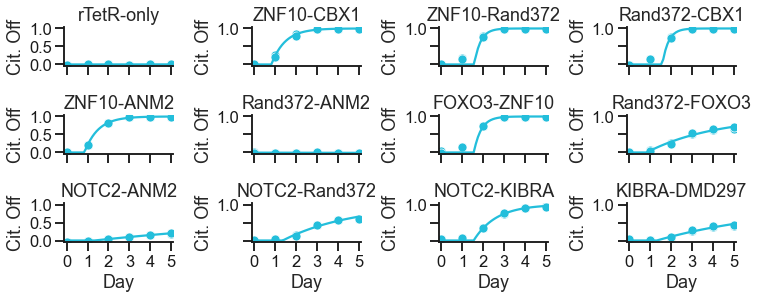

In [18]:
%%time

g = sns.FacetGrid(
    data=rdf,
    col="plasmid",
    col_wrap=4,
    col_order=repadd_plasmids,
    height=1.5,
    aspect=1.75,
)

g.map_dataframe(sns.scatterplot, x="day", y="norm Citrine Off", color="#23bedb")

param_df_list = []

for i, ax in enumerate(g.axes):
    px = repadd_plasmids[i]
    xdf = rdf[rdf["plasmid"] == px]

    def sil_curve(t, kS, tLag1):
        return 0.0 * (t < tLag1) + (1 - np.exp(-1 * kS * (t - tLag1))) * (t >= tLag1)

    xvalues = list(xdf["day"])
    yvalues = list(xdf["norm Citrine Off"])
    popt, pcov = curve_fit(sil_curve, xvalues, yvalues)
    fit_x = list(np.linspace(0.01, 5))
    fit_y = sil_curve(fit_x, *popt)
    ax.plot(fit_x, fit_y, color="#23bedb")

    ks, tl1 = popt
    param_df_list.append(
        pd.DataFrame.from_dict(
            {
                "plasmid": [px],
                "description": [plasmid_dict[px]],
                "ks": [ks],
                "tlag": [tl1],
            }
        )
    )

    ax.set_title(plasmid_dict[px])

    ax.set_xlim(-0.1, 5.1)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel("Day")
    ax.set_ylabel("Cit. Off")

g.add_legend()

plt.tight_layout()

g.savefig("./plots/repression_omnibus.pdf", bbox_inches="tight")

In [19]:
for i, px in enumerate(repadd_plasmids):
    fig, ax = plt.subplots(figsize=(3, 1))
    xdf = rdf[rdf["plasmid"] == px]

    sns.scatterplot(data=xdf, x="day", y="norm Citrine Off", color="#23bedb", ax=ax)

    def sil_curve(t, kS, tLag1):
        return 0.0 * (t < tLag1) + (1 - np.exp(-1 * kS * (t - tLag1))) * (t >= tLag1)

    xvalues = list(xdf["day"])
    yvalues = list(xdf["norm Citrine Off"])
    popt, pcov = curve_fit(sil_curve, xvalues, yvalues)
    fit_x = list(np.linspace(0.01, 5))
    fit_y = sil_curve(fit_x, *popt)
    ax.plot(fit_x, fit_y, color="#23bedb")

    ax.set_title(plasmid_dict[px])

    ax.set_xlim(-0.1, 5.2)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel("Day")
    ax.set_ylabel("Norm Cit Off")
    
    sns.despine()

    fig.savefig(
        "./plots/" + str(plasmid_dict[px]) + "_lineplot.pdf", bbox_inches="tight"
    )
    plt.close("all")

In [20]:
param_df = pd.concat(param_df_list)
param_df.to_csv("./data/parameter_df.csv", index = False)
param_df

,plasmid,description,ks,tlag
0,126,rTetR-only,0.000378,-0.000002
0,77,ZNF10-CBX1,1.542290,0.831848
0,181,ZNF10-Rand372,3.317233,1.564606
0,182,Rand372-CBX1,3.414861,1.595006
0,76,ZNF10-ANM2,1.545607,0.854654
0,183,Rand372-ANM2,-0.001094,-4.186344
0,140,FOXO3-ZNF10,2.854710,1.546131
0,184,Rand372-FOXO3,0.303138,0.849036
0,90,NOTC2-ANM2,0.061588,1.333417
0,188,NOTC2-Rand372,0.299940,1.371768


# Correlating with other data

In [21]:
param_df["date"] = "2022-04-22"
param_df

,plasmid,description,ks,tlag,date
0,126,rTetR-only,0.000378,-0.000002,2022-04-22
0,77,ZNF10-CBX1,1.542290,0.831848,2022-04-22
0,181,ZNF10-Rand372,3.317233,1.564606,2022-04-22
0,182,Rand372-CBX1,3.414861,1.595006,2022-04-22
0,76,ZNF10-ANM2,1.545607,0.854654,2022-04-22
0,183,Rand372-ANM2,-0.001094,-4.186344,2022-04-22
0,140,FOXO3-ZNF10,2.854710,1.546131,2022-04-22
0,184,Rand372-FOXO3,0.303138,0.849036,2022-04-22
0,90,NOTC2-ANM2,0.061588,1.333417,2022-04-22
0,188,NOTC2-Rand372,0.299940,1.371768,2022-04-22


In [22]:
old_param_df = pd.read_csv("../2021.11.17_repression_round1/data/paramed_concats.csv")
old_param_df = old_param_df[["plasmid", "description", "ks", "tlag"]]
old_param_df["date"] = "2021-11-17"
old_param_df

,plasmid,description,ks,tlag,date
0,75,DMD - RANDCTRL,0.025537,1.805088,2021-11-17
1,78,RANDCTRL - RANDCTRL,0.075796,1.294637,2021-11-17
2,79,ANM2 - KIBRA,0.026153,0.668837,2021-11-17
3,81,CACO1 - ANM2,0.016807,1.395714,2021-11-17
4,90,NOTC2 - ANM2,0.035116,-0.097437,2021-11-17
5,91,NOTC2 - KIBRA,0.770373,0.921121,2021-11-17
6,98,CHD4 - CDYL2,4.004496,0.916357,2021-11-17
7,82,CREM - MPP8,3.088496,0.950128,2021-11-17
8,87,MPP8 - ZNF791,3.403814,0.934646,2021-11-17
9,94,YAF2 - ZNF791,3.973450,0.927227,2021-11-17


In [23]:
params = pd.concat([param_df, old_param_df])
params

,plasmid,description,ks,tlag,date
0,126,rTetR-only,0.000378,-0.000002,2022-04-22
0,77,ZNF10-CBX1,1.542290,0.831848,2022-04-22
0,181,ZNF10-Rand372,3.317233,1.564606,2022-04-22
0,182,Rand372-CBX1,3.414861,1.595006,2022-04-22
0,76,ZNF10-ANM2,1.545607,0.854654,2022-04-22
0,183,Rand372-ANM2,-0.001094,-4.186344,2022-04-22
0,140,FOXO3-ZNF10,2.854710,1.546131,2022-04-22
0,184,Rand372-FOXO3,0.303138,0.849036,2022-04-22
0,90,NOTC2-ANM2,0.061588,1.333417,2022-04-22
0,188,NOTC2-Rand372,0.299940,1.371768,2022-04-22


In [24]:
screen_data = pd.read_csv('../../01_repressor_additivity/pairs_baselinesums.csv')
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,2.054285,0.493242,Repressor,Non-hit,A-N,Other,True,False,1.126839,2.462512
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,0.351655,0.582309,Repressor,Activator,A-A,Activator,True,True,5.959180,0.703310
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,-0.808308,0.670493,Repressor,Repressor,R-R,Repressor,False,True,-3.901673,-1.616616
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.745666,0.626952,Activator,Activator,A-A,Activator,True,True,5.391484,1.491332
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,1.827117,0.364559,Repressor,Non-hit,R-N,Other,False,True,-3.468438,-1.219896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.449007,0.414017,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.146319,-2.566018
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.750528,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.969341,-1.916518
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.750528,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.913868,-2.867540
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.281728,0.818380,Activator,Non-hit,C-N,Other,NaN,NaN,-2.354220,3.115738


In [25]:
oligos = pd.read_csv(
    "../../../fig_1/01_raw_counts/csvs/base_oligo_library.csv"
)


def domain_from_gene(g):
    if g == "Rand372":
        return "Random_control;;;372;"
    elif g == "Ctrl" or g == "CTRL" or g == "DMD297":
        return "DMD_control_tiles;ENSG00000198947;;297;"
    else:
        of = oligos[oligos["Gene"] == g]
        assert len(list(of["label"])) == 1
        return list(of["label"])[0]


def get_domains(plasmid, description):
    if plasmid == 75:
        return ["DMD_control_tiles;ENSG00000198947;;297;", "Random_control;;;21;"]
    elif plasmid == 74:
        return [
            "DMD_control_tiles;ENSG00000198947;;131;",
            "DMD_control_tiles;ENSG00000198947;;297;",
        ]
    elif plasmid == 78:
        return ["Random_control;;;205;", "Random_control;;;410;"]
    # find the domain for each of the elements
    if " - " not in description:
        print(plasmid, description)
    d1, d2 = description.split(" - ")
    return [domain_from_gene(d1), domain_from_gene(d2)]

In [26]:
params = params[params["plasmid"] != 126]
params["description"] = [
    d if " - " in d else d.replace("-", " - ") for d in list(params["description"])
]
params

pairs = [
    get_domains(p, d)
    for p, d in zip(list(params["plasmid"]), list(params["description"]))
]
params["domain1"] = [p[0] for p in pairs]
params["domain2"] = [p[1] for p in pairs]
params["pair"] = [p[0] + " --- " + p[1] for p in pairs]
params

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_30708/1826208252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_30708/1826208252.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_30708/1826208252.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,plasmid,description,ks,tlag,date,domain1,domain2,pair
0,77,ZNF10 - CBX1,1.542290,0.831848,2022-04-22,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,Human_KRAB_variant;P21506;146 --- Short_nuclea...
0,181,ZNF10 - Rand372,3.317233,1.564606,2022-04-22,Human_KRAB_variant;P21506;146,Random_control;;;372;,Human_KRAB_variant;P21506;146 --- Random_contr...
0,182,Rand372 - CBX1,3.414861,1.595006,2022-04-22,Random_control;;;372;,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,Random_control;;;372; --- Short_nuclear_domain...
0,76,ZNF10 - ANM2,1.545607,0.854654,2022-04-22,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Human_KRAB_variant;P21506;146 --- Short_nuclea...
0,183,Rand372 - ANM2,-0.001094,-4.186344,2022-04-22,Random_control;;;372;,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Random_control;;;372; --- Short_nuclear_domain...
0,140,FOXO3 - ZNF10,2.854710,1.546131,2022-04-22,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,Human_KRAB_variant;P21506;146,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;...
0,184,Rand372 - FOXO3,0.303138,0.849036,2022-04-22,Random_control;;;372;,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,Random_control;;;372; --- Short_nuclear_domain...
0,90,NOTC2 - ANM2,0.061588,1.333417,2022-04-22,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34...
0,188,NOTC2 - Rand372,0.299940,1.371768,2022-04-22,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34,Random_control;;;372;,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34...
0,91,NOTC2 - KIBRA,0.931504,1.538086,2022-04-22,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34,Short_nuclear_domain;KIBRA_HUMAN;WW;1;29,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34...


In [27]:
jdf = params.set_index('pair').join(
    screen_data.set_index('pair'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
jdf

,pair,plasmid,description,ks,tlag,date,domain1,domain2,type,enrichment_ratio_r1_d2,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,75,DMD - RANDCTRL,0.025537,1.805088,2021-11-17,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,2 control Pair,-1.657747,...,-0.117011,1.669026,Control,Control,C-C,Control,False,False,NaN,NaN
1,Human_KRAB_variant;P21506;146 --- Random_contr...,181,ZNF10 - Rand372,3.317233,1.564606,2022-04-22,Human_KRAB_variant;P21506;146,Random_control;;;372;,1 control Pair,-2.876175,...,0.427169,1.998826,Control,Control,R-C,Repressor,False,True,-3.935008,-2.671694
2,Human_KRAB_variant;P21506;146 --- Short_nuclea...,76,ZNF10 - ANM2,1.545607,0.854654,2022-04-22,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,-3.060923,...,1.788448,0.450569,Activator,Activator,R-A,Both,False,True,-2.290708,-1.310415
3,Human_KRAB_variant;P21506;146 --- Short_nuclea...,76,ZNF10 - ANM2,3.178141,0.938369,2021-11-17,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,-3.060923,...,1.788448,0.450569,Activator,Activator,R-A,Both,False,True,-2.290708,-1.310415
4,Human_KRAB_variant;P21506;146 --- Short_nuclea...,77,ZNF10 - CBX1,1.542290,0.831848,2022-04-22,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,0 control Pair,-2.264251,...,-2.750528,0.642879,Repressor,Repressor,R-R,Repressor,False,True,-5.247002,-5.849392
5,Human_KRAB_variant;P21506;146 --- Short_nuclea...,77,ZNF10 - CBX1,2.959320,0.926428,2021-11-17,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,0 control Pair,-2.264251,...,-2.750528,0.642879,Repressor,Repressor,R-R,Repressor,False,True,-5.247002,-5.849392
6,Random_control;;;205; --- Random_control;;;410;,78,RANDCTRL - RANDCTRL,0.075796,1.294637,2021-11-17,Random_control;;;205;,Random_control;;;410;,2 control Pair,-1.120361,...,0.732395,1.717955,Control,Control,C-C,Control,False,False,-2.929481,0.671557
7,Random_control;;;372; --- Short_nuclear_domain...,183,Rand372 - ANM2,-0.001094,-4.186344,2022-04-22,Random_control;;;372;,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,1 control Pair,0.117576,...,1.788448,0.450569,Activator,Activator,C-A,Activator,False,False,-1.323747,2.215617
8,Random_control;;;372; --- Short_nuclear_domain...,182,Rand372 - CBX1,3.414861,1.595006,2022-04-22,Random_control;;;372;,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,1 control Pair,-2.629184,...,-2.750528,0.642879,Repressor,Repressor,C-R,Repressor,False,True,-4.280041,-2.323359
9,Random_control;;;372; --- Short_nuclear_domain...,184,Rand372 - FOXO3,0.303138,0.849036,2022-04-22,Random_control;;;372;,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,1 control Pair,2.895843,...,0.111979,0.639032,Activator,Activator,C-A,Activator,True,True,1.658997,0.539148


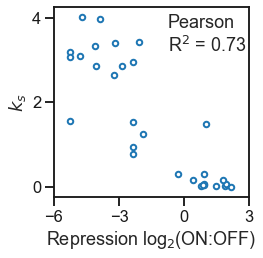

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

sns.scatterplot(
    data=jdf,
    x="avg_enrichment_d5",
    y="ks",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_xlim(-6, 3)
ax.set_xticks([-6, -3, 0, 3])
ax.set_ylim(-0.25, 4.25)
ax.set_yticks([0, 2, 4])

xdf = jdf.dropna(subset=['avg_enrichment_d5', 'ks'])
r, p = st.pearsonr(xdf['avg_enrichment_d5'], xdf['ks'])
ax.text(-0.75, 3.2, "Pearson\nR$^2$ = {:.2f}".format(r**2))

ax.set_xlabel('Repression log$_2$(ON:OFF)')
ax.set_ylabel('$k_s$')

fig.savefig('./repressor_full_correlation.pdf', bbox_inches = 'tight')

In [ ]:
def f_sigmoid(s, thresh, kd, n):
    if isinstance(s, int) or isinstance(s, float):
        s = np.array([s])
    elif isinstance(s, list):
        s = np.array(s)
    # else we assume np array 
    res = [0 for _ in s]
    for i, v in enumerate(s):
        if v <= thresh:
            res[i] = np.float_power(v-thresh, n)/(
                np.float_power(v-thresh, n) + np.float_power(kd, n)
            )
    return res

In [29]:
np.nanmax(jdf['avg_enrichment_d5'])

2.1441050892194373

# Repressor Additivity Analysis

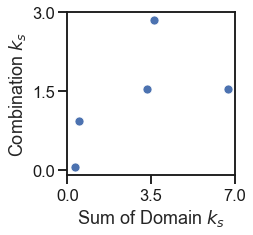

In [30]:
add_df = jdf[jdf["date"] == "2022-04-22"]

# the setup we have is
# 181 + 183 => 76
# 181 + 182 => 77
# 181 + 184 => 140
# 188 + 183 => 90
# 188 + 138 => 91


def get_validation_ks(plasmid):
    return list(add_df[add_df["plasmid"] == plasmid]["ks"])[0]


d1_list = [181, 181, 181, 188, 188]
d2_list = [183, 182, 184, 183, 138]
dp_list = [76, 77, 140, 90, 91]

add_df = pd.DataFrame.from_dict(
    {
        "domain1": [plasmid_dict[d] for d in d1_list],
        "domain2": [plasmid_dict[d] for d in d2_list],
        "combo": [plasmid_dict[d] for d in dp_list],
        "d1_ks": [get_validation_ks(d) for d in d1_list],
        "d2_ks": [get_validation_ks(d) for d in d2_list],
        "dp_ks": [get_validation_ks(d) for d in dp_list],
    }
)
add_df["ds_ks"] = add_df["d1_ks"] + add_df["d2_ks"]

fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(data=add_df, x="ds_ks", y="dp_ks", ax=ax)

ax.set_xlabel("Sum of Domain $k_s$")
ax.set_ylabel("Combination $k_s$")
ax.set_xlim([0, 7])
ax.set_xticks([0, 3.5, 7])
ax.set_ylim([-0.1, 3])
ax.set_yticks([0, 1.5, 3])

fig.savefig("./repressor_validation_sumcorr.pdf", bbox_inches="tight")

In [31]:
add_df

,domain1,domain2,combo,d1_ks,d2_ks,dp_ks,ds_ks
0,ZNF10-Rand372,Rand372-ANM2,ZNF10-ANM2,3.317233,-0.001094,1.545607,3.316139
1,ZNF10-Rand372,Rand372-CBX1,ZNF10-CBX1,3.317233,3.414861,1.542290,6.732094
2,ZNF10-Rand372,Rand372-FOXO3,FOXO3-ZNF10,3.317233,0.303138,2.854710,3.620371
3,NOTC2-Rand372,Rand372-ANM2,NOTC2-ANM2,0.299940,-0.001094,0.061588,0.298846
4,NOTC2-Rand372,KIBRA-DMD297,NOTC2-KIBRA,0.299940,0.168434,0.931504,0.468375
